#  Handwritten digits classifier in a Jupyter Notebook

## Introduction
This project uses neural network models to predict handwriten digits. Two models are presented: a simple feedforward neural network model, and a convolutional neural network model. Models are trained on MNIST handwritten digit database, and their goal is to predict digits on any handwritten dana (any dimension, color etc.).<br>
The idea in this project is to transform input image to have similar features as mnist images do, and then predict digit with one of the two models. Function transformtomnist() is used for this transformation. Transformed image has 28x28 pixels, digits are white, background is black, and digits are inside of a center 20x20 box.
* First model got one fully connected hidden layer with 50 nodes (chosen after a few tries).
* Second model is convolutional neural network presented in [this Keras example](https://keras.io/examples/mnist_cnn/).

Some new images are generated by using random rotation, shear mapping, and narrower digit thickness of training set. These images are also used for training convolutional neural network model.<br>
I wrote some digits on a piece of paper and took a photo of them. After using transformtomnist() on these images, I tested my models on them.<br>
## Code

In [ ]:
import sys

Installing required python packages if you are using pip.

In [ ]:
%pip install tensorflow 
%pip install opencv-python 
%pip install keras 
%pip install numpy 
%pip install matplotlib

Installing required python packages if you are using conda.

In [ ]:
!conda install --yes --prefix {sys.prefix} tensorflow
!conda install --yes --prefix {sys.prefix} opencv
!conda install --yes --prefix {sys.prefix} keras
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} matplotlib

In [ ]:
import tensorflow as tf
import cv2
import os
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import ndimage
import tkinter as tk
from tkinter import filedialog
from tkinter import *
%matplotlib inline

### Function to transform input image to 28x28 pixels with similar features as mnist images.

In [ ]:
def transformtomnist(gray):
    
    # transforming image to 28x28 pixels and to have white digit and black background
    gray = cv2.resize(255 - gray, (28, 28))
    (thresh, gray) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    if np.mean(gray)>128:
        gray = cv2.resize(255 - gray, (28, 28))
    
    # transforming image to have digit inside of a center 20x20 box
    while np.sum(gray[0]) == 0:
        gray = gray[1:]
    while np.sum(gray[:, 0]) == 0:
        gray = np.delete(gray, 0, 1)
    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]
    while np.sum(gray[:, -1]) == 0:
        gray = np.delete(gray, -1, 1)
    rows, cols = gray.shape
    if rows > cols:
        factor = 20.0 / rows
        rows = 20
        cols = int(round(cols * factor))
        gray = cv2.resize(gray, (cols, rows))
    else:
        factor = 20.0 / cols
        cols = 20
        rows = int(round(rows * factor))
        gray = cv2.resize(gray, (cols, rows))
    colsPadding = (int(math.ceil((28 - cols) / 2.0)), int(math.floor((28 - cols) / 2.0)))
    rowsPadding = (int(math.ceil((28 - rows) / 2.0)), int(math.floor((28 - rows) / 2.0)))
    gray = np.lib.pad(gray, (rowsPadding, colsPadding), 'constant')
    
    return gray

<br>Printing two gray examples of handwritten digit pictures (I made) before and after editing them with the transformtomnist() function. I made a negative of 7.png picture to make an example of a input image with a light color digit and a dark color background.

In [ ]:
print('original gray pictures:')
picture1 = cv2.imread('6.png', 0)
plt.imshow(picture1, cmap='gray')
plt.show()
picture2 = cv2.imread('7.png', 0)
plt.imshow(picture2, cmap='gray')
plt.show()
print('after editing:')
picture1 = transformtomnist(picture1)
plt.imshow(picture1, cmap='gray')
plt.show()
picture2 = transformtomnist(picture2)
plt.imshow(picture2, cmap='gray')
plt.show()

### First model: one-layer neural network without data augmentation. 
Even though I did not choose hyperparameters too carefully, this model got ~97% accuracy on the mnist test set.

In [ ]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28


(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

x_tr = x_tr.astype('float32')
x_te = x_te.astype('float32')
x_tr /= 255
x_te /= 255
y_tr = keras.utils.to_categorical(y_tr, num_classes)
y_te = keras.utils.to_categorical(y_te, num_classes)

model1 = Sequential()
model1.add(Flatten(input_shape=(28, 28)))
model1.add(Dense(50, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(x_tr, y_tr,
          batch_size=100,
          epochs=30,
          verbose=2,
          validation_data=(x_te, y_te))

score = model1.evaluate(x_te, y_te, verbose=0)
print('\nAccuracy of the neural network model on mnist test set:', score[1])

### Adding mnist digits with a narrower thickness and preparing data for training the convolutional neural network (with rotation and shear mapping).
Mnist digits are wide relative to the background (especially if you compare them with a digit written with a pen on a piece of paper). For this reason, I added some narrower digits in a training set.<br>
I am also using random rotation and shear mapping in case a photo of an input image was taken from a weird angle.<br>
I thought that shifting and some other data augmentation technics are not particularly useful, because I am using transformtomnist() function.

In [ ]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


kernel = np.ones((2, 2), np.uint8)
l=len(x_train)
print('generating mnist digits with a narrower thickness for training...')
# I am making narrower version of every fifth digit to make the code run faster.
for i in range(0, l, 5):
    picture = x_train[i]
    er = cv2.erode(picture, kernel, iterations=1).reshape(1,28,28)
    x_train = np.append(x_train, er, axis=0)
    y_train = np.append(y_train, y_train[i])
    # optional: adding wider digits
    # di = cv2.dilate(picture, kernel, iterations=1).reshape(1,28,28)
    # x_train = np.append(x_train, di, axis=0)
    # y_train = np.append(y_train, y_train[i])
print('...done generating') 

# preparing data shape for the convolutional neural network model
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# rotation and shear mapping
datagen = ImageDataGenerator(rotation_range=30, shear_range=0.2)
datagen.fit(x_train)

### Convolutional neural network model with data augmentation.
I tested this model on the original mnist data set and got ~99% accuracy (both with and without data augmentation). Even though data augmentation described above does not look useful for the model if it is tested on the original mnist data set, the model could work better on some other handwritten digit data set.

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print('Training the convolutional neural network model (this training took ~30min on my laptop CPU)...')
# training the model without rotation and shear mapping
# model2.fit(x_train, y_train, batch_size=128, epochs=12, verbose=2,validation_data=(x_test, y_test))

# training the model with rotation and shear mapping
model2.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=12, verbose=2,validation_data=(x_test, y_test))

score = model2.evaluate(x_test, y_test, verbose=0)
print('\nAccuracy of the convolutional neural network model on mnist test set:', score[1])

### Testing my models on the handwritten digits I wrote.
Both models predicted correctly 10 out of 10 digits.<br>

In [ ]:
for number in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    gray = cv2.imread(number+'.png', 0)
    gray = transformtomnist(gray)/255
    ss1 = np.array(gray).reshape(1, 28, 28)
    ss2 = np.array(gray).reshape(1, 28, 28, 1)
    print('digit is '+number+' = NN output: ', np.argmax(model1.predict([ss1])))
    print('digit is '+number + ' = Cov net output: ', np.argmax(model2.predict([ss2])))

### Input your image
Input your image by adding file path (4. line of the next cell), or by selecting it in a file browser after running the next cell.

In [ ]:
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
file_path = 'file path'
if file_path=='file path':
    file_path = filedialog.askopenfilename()

Print input image and outputs of the models.

input image: 


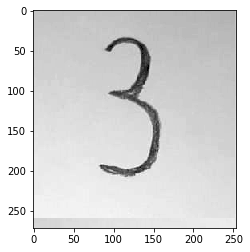

Output of the neural network model is:  3
Output of the convolutional neural network model is:  3


In [13]:
image = cv2.imread(file_path, 0)
print('input image: ')
plt.imshow(image, cmap='gray')
plt.show()
image = transformtomnist(image)/255
rs1 = np.array(image).reshape(1, 28, 28)
rs2 = np.array(image).reshape(1, 28, 28, 1)
print('Output of the neural network model is: ', np.argmax(model1.predict([rs1])))
print('Output of the convolutional neural network model is: ', np.argmax(model2.predict([rs2])))

## Conclusion
Both models reached high accuracy on both mnist test set, and my handwritten digits.<br>
Improving transformtomnist() function had a huge impact on accuracy of the models on my handwritten digits.<br>
Adding narrower thickness digits, and using rotation and shear mapping, was neither harmful neither helpful for tests described in this project, but it would be interesting to see if it helps the model to give better results on some other data set.
